# Biomedical Imaging 4C16/5C16 Project

## Tumor Segmentation & Classification

#### About the dataset

You have been given a dataset of ultrasound scans and segmentation maps associated with these ultrasound scans. These scans are to be used for training networks for ***breast cancer tumor segmentation and classification***.

The dataset has already been prepared to numpy files and is in the 'dataset' directory and is of the following structure:

- *dataset/*
    - *benign/*
        - *input.npy*
        - *target.npy*
    - *malignant/*
        - *input.npy*
        - *target.npy*
    - *normal/*
        - *input.npy*
        - *target.npy*

The *input.npy* and *output.npy* files are the input ultrasound scans and target segmentation maps for that tumor category (benign, malignant, normal).

- All input ultrasound scans are images of size 128x128x3. This means the height and width of these images are 128 and it is stored in RGB space. The pixels range from 0-1.
- All segmentation maps are images of size 128x128x1. This is an image where a value of 1 means that a tumor is detected at that location, and 0 means there is no tumor present.

The code block below displays examples of ultrasound scans and tumor segmentation maps for these image pairs.

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
%cd /content/gdrive/MyDrive/4c16-labs/code/lab-06/

Mounted at /content/gdrive
/content/gdrive/MyDrive/4c16-labs/code/lab-06


In [ ]:
# IMPORTING NECESSARY MODULES

import tensorflow as tf

import keras
from keras import datasets
from keras.layers import Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPool2D, Lambda
from keras.regularizers import l2

from keras.models import model_from_json

from keras import layers, models

from IPython.display import clear_output

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.ticker import MaxNLocator

import pickle
import sklearn as skl

from sklearn import datasets, linear_model
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split

In [ ]:

# Define some useful functions
class PlotLossAccuracy(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.acc = []
        self.losses = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):

        self.logs.append(logs)
        self.x.append(int(self.i))
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.acc.append(logs.get('accuracy'))
        self.val_acc.append(logs.get('val_accuracy'))

        self.i += 1

        clear_output(wait=True)
        plt.figure(figsize=(16, 6))
        plt.plot([1, 2])
        plt.subplot(121)
        plt.plot(self.x, self.losses, label="train loss")
        plt.plot(self.x, self.val_losses, label="validation loss")
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.title('Model Loss')
        plt.legend()
        plt.subplot(122)
        plt.plot(self.x, self.acc, label="training accuracy")
        plt.plot(self.x, self.val_acc, label="validation accuracy")
        plt.legend()
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.title('Model Accuracy')
        plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
        plt.show();

# Function to save a model
def save_model_to_disk(model, filename_base):
    # save model and weights (don't change the filenames)
    model_json = model.to_json()
    with open(filename_base + ".json", "w") as json_file:
        json_file.write(model_json)
    # serialize weights to HDF5
    model.save_weights(f"{filename_base}.h5")
    print("Saved model to model.json and weights to model.h5")


In [ ]:
# Download the dataset
!curl --create-dirs -o /home/tcd/data/medicalimaging-dataset.zip https://tcddeeplearning.blob.core.windows.net/deeplearning202324/medicalimaging-dataset.zip

!mkdir -p /home/tcd/data/medicalimaging/
!unzip -o /home/tcd/data/medicalimaging-dataset.zip -d /home/tcd/data/medicalimaging/

# Dataset is located in /home/tcd/data/medicalimaging/

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 16.1M  100 16.1M    0     0  3334k      0  0:00:04  0:00:04 --:--:-- 3776k
Archive:  /home/tcd/data/medicalimaging-dataset.zip
  inflating: /home/tcd/data/medicalimaging/dataset/normal/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/benign/input.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/malignant/target.npy  
  inflating: /home/tcd/data/medicalimaging/dataset/normal/target.npy  


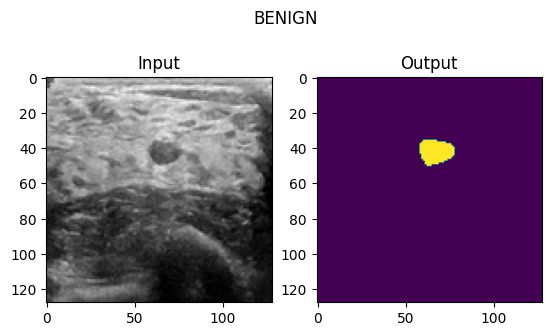

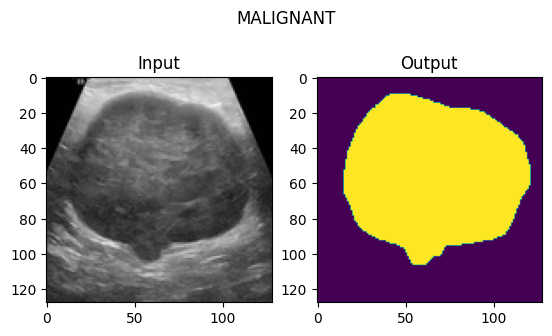

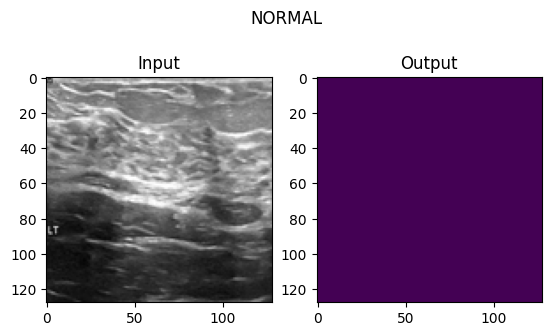

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random

for _type in ['benign', 'malignant', 'normal']:
    X = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/input.npy')
    y = np.load(f'/home/tcd/data/medicalimaging/dataset/{_type}/target.npy')
    randomExample = random.randint(0, X.shape[0] - 1)
    fig, axs = plt.subplots(1, 2)
    axs[0].imshow(X[randomExample])
    axs[0].title.set_text('Input')
    axs[1].imshow(y[randomExample])
    axs[1].title.set_text('Output')
    fig.suptitle(_type.upper())
    plt.subplots_adjust(top=1.1)
    plt.show()

### The problem

You are required to train two separate neural networks for the purposes of:

1. **Classification Task**: Predicting whether an ultrasound is a) benign tumor,  b) contains a malignant tumor or c) normal (no-tumor).
    - Input are ultra sound scans (data from benign/malignant/normal), the output is a vector of the 3 probabilities for the classes (benign/malignant/normal) in that order (eg. [0.01, 0.99, 0] means the outcome is more likely to be malignant).
2. **Segmentation Task**: Predicting the segmentation map for a tumor of an input MRI scan if a tumor exists
    - Input are ultra sound scans (data from benign/malignant/normal), output is an image with the same height and width as the input image, but with only one channel and a value of 1 over the location where a tumor is present.

---

*IMPORTANT*

For Task 1, your model should be created with the name: 'classification_model',
the model size should be under 5M

For Task 2, your model should be created with the name: 'segmentation_model',
the model size should be under 3M.

In [ ]:
# Hints:
#
# Load data into appropriate input/output formats.
# For example, for problem 1:
#   * inputs should be a collection of images of size [n_samples x height x width x 3],
#   * outputs should be of size [n_samples x height x width x 1].
#
# Load images using the `np.load` function. You can combine tensors using `np.concat`
# to form a single input or output dataset tensor. Look at previous labs for inspiration
# on what datasets look like.
#
# The amount of training data is very low, so usage of data
# augmentation techniques is strongly advised.(eg. see tf.keras.layers.RandomRotation)
#
# Classification Task hint: you may also think of using pre-trained networks
# with fine-tuning.
# Keep the model size under the restriction of 5Million parameters, you should
# be able to hit the target at much less model size. (Lower the better:))
#
# Segmentation Task hint: You might want to use transpose convolution layers to go up in tensor size.
# Popular segmentation architectures include U-Net (with skip-connections) or DnCNN.
# Keep the model size under the restriction of 3 Million parameters, you should
# be able to hit the target at very much lower model size. (Lower the better:))








In [ ]:
#LOADING THE DATA:

#loading input data from files using numpy load function
benign_data = np.load('/home/tcd/data/medicalimaging/dataset/benign/input.npy')
malignant_data = np.load('/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
normal_data = np.load('/home/tcd/data/medicalimaging/dataset/normal/input.npy')

In [ ]:
import numpy as np
from sklearn.model_selection import train_test_split

#CREATE LABELS FOR THE THREE CLASSES

#creating one-hot encoded labels for three classes used to represent categorical variables in classification
#each class is represented by a unique vector of length equal to the number of classes
#each label variable is a 2D NumPy array where each row corresponds to the one-hot encoded label
benign_labels = np.array([[1, 0, 0]] * len(benign_data))
malignant_labels = np.array([[0, 1, 0]] * len(malignant_data))
normal_labels = np.array([[0, 0, 1]] * len(normal_data))


# CONCATENATE DATA AND LABELS FOR ALL THREE CLASSES

#used to join together multiple arrays along a specified axis.
#effectively combining the training sets for different classes into a unified training and validation set.
X = np.concatenate((benign_data, malignant_data, normal_data), axis=0)
Y = np.concatenate((benign_labels, malignant_labels, normal_labels),axis=0)


# SPLIT INTO TRAINING AND TESTING SETS

#splits the input data for each class into training and validation sets
X_training, X_validation, Y_training, Y_validation = train_test_split(X, Y, test_size=.1)


In [ ]:
import tensorflow as tf #machine learning framework used for deep learning models

import keras #high-level neural networks API
from keras import datasets
from keras.models import Sequential
from keras.layers import Input, Dense, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import PReLU, LeakyReLU, Conv2D, MaxPooling2D, Lambda
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.regularizers import l2

inputs = keras.layers.Input(shape=(128, 128, 3))
x = inputs

# DATA AUGMENTATION

# applies random transformation to input data during training, helping improve the generalization ability of the model
# by exposing it to a broader range of variations in the training data.
x = tf.keras.layers.RandomFlip("vertical")(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomFlip("vertical")(x)
x = tf.keras.layers.RandomRotation(0.2)(x)


# x = Conv2D(16,kernel_size=(3,3),activation='relu')(x)
# x = MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(x)
# BatchNormalization()


# 2D Conv layers effective for image data as they can detect local patterns and hierarchies of features.
# Maxpool summarize the most activated presence of a feature.
# used to down sample the detection of features in feature maps, while preserving the all important features.
# batchN help stabilize and accelerate the training process by normalizing the input to each layer
x = Conv2D(32,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding="same")(x)
BatchNormalization()
#Dropout(0.1)

x = Conv2D(filters=64,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
BatchNormalization()
#Dropout(0.1)

x = Conv2D(filters=128,kernel_size=(3,3),activation='relu')(x)
x = MaxPooling2D(pool_size=(3,3),strides=2,padding='same')(x)
BatchNormalization()
#Dropout(0.1)

# flatten layer used to convert multi-dimensional input into 1D array
x = Flatten()(x)

# fully connected layer where each neuron or node in the layer is connected to every neuron in the previous layer
x= Dense(128,activation='relu')(x)
# Dropout(0.1)
predictions = Dense(3, activation='softmax')(x)

# CREATE MODEL, OPTIMISERS AND COMPILE

# model is trained using categorical crossentropy loss, SGD optimizer, and accuracy as the evaluation metric.
model = keras.models.Model(inputs=inputs, outputs=predictions)
opt = keras.optimizers.legacy.SGD(learning_rate=0.0001, decay=1e-6, momentum=0.9, nesterov=True)

# CC measures the dissimilarity between the predicted probability distribution and the true probability distribution.
# CC entopy commonly used for multi-class classification problems.
model.compile(optimizer=opt,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 random_flip_1 (RandomFlip)  (None, 128, 128, 3)       0         
                                                                 
 random_rotation_1 (RandomR  (None, 128, 128, 3)       0         
 otation)                                                        
                                                                 
 conv2d (Conv2D)             (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 63, 63, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 64)        18496 

In [ ]:
import matplotlib.pyplot as plt

# we create a callback function to plot our loss function and accuracy
pltCallBack = PlotLossAccuracy()

# and train
model.fit(X_training, Y_training,
          batch_size=5, epochs=95,
          validation_data=(X_validation, Y_validation),
          callbacks=[pltCallBack])

# If you run this cell again, the optimisation starts where you left it.
# For instance, if you have set epochs=40 in the model.fit call,
# and that you run the cell 3 times, then you are effectively running for
# 120 iterations.

In [ ]:
classification_model = model
if (classification_model.count_params()  < 5000000) :
  save_model_to_disk(classification_model, "classification_model")
else:
  print("Your model is unecessarily complex, scale down!")

In [ ]:
# LOAD INPUT DATA FROM FILE
data_benign= np.load('/home/tcd/data/medicalimaging/dataset/benign/input.npy')
data_malignant = np.load('/home/tcd/data/medicalimaging/dataset/malignant/input.npy')
data_normal = np.load('/home/tcd/data/medicalimaging/dataset/normal/input.npy')

# LOAD SEGMENTATION TARGET DATA FROM FILE
benign_data_seg = np.load('/home/tcd/data/medicalimaging/dataset/benign/target.npy')
malignant_data_seg = np.load('/home/tcd/data/medicalimaging/dataset/malignant/target.npy')
normal_data_seg = np.load('/home/tcd/data/medicalimaging/dataset/normal/target.npy')

# loading input data and segmentation target data from files using numpy load function

In [ ]:
from sklearn.model_selection import train_test_split

# SPLIT INPUT DATA INTO TRAINING AND VALIDATION SETS

# splits the input data for each class into training and validation sets
X_train_benign, X_val_benign, Y_train_benign, Y_val_benign = train_test_split(data_benign, benign_data_seg, test_size=.3)
X_train_malignant, X_val_malignant, Y_train_malignant, Y_val_malignant = train_test_split(data_malignant,malignant_data_seg, test_size=.3)
X_train_normal, X_val_normal, Y_train_normal, Y_val_normal = train_test_split(data_normal, normal_data_seg,test_size=.3)


In [ ]:
# CONCATENATE DATA FROM DIFFERENT CLASSES FOR TRAINING SETS
X_train = np.concatenate((X_train_benign, X_train_normal, X_train_malignant), axis=0)
Y_train = np.concatenate((Y_train_benign, Y_train_normal, Y_train_malignant),axis=0)

# CONCATENATE DATA FROM DIFFERENT CLASSES FOR VALIDATION SETS
X_val = np.concatenate((X_val_benign, X_val_normal, X_val_malignant), axis=0)
Y_val = np.concatenate((Y_val_benign, Y_val_normal, Y_val_malignant),axis=0)

#used to join together multiple arrays along a specified axis
#effectively combining the training and validation sets for diff classes into a unified training and validation set.


# RESHAPE TARGET DATA TO MATCH THE MODEL'S OUTPUT SHAPE
#Y_train = Y_train.reshape((-1, 128, 128, 1))
#Y_val = Y_val.reshape((-1, 128, 128, 1))

In [ ]:

from keras.layers import Conv2D, MaxPool2D, Dropout, Conv2DTranspose, BatchNormalization, Input, UpSampling2D
from keras.models import Model
from keras.optimizers import Adam # dynamically adjusts the learning rates for each parameter in the neural network

inputs = keras.layers.Input(shape=(128, 128, 3))

# DATA AUGMENTATION

# applies random transformation to input data during training, helping improve the generalization ability of the model
# by exposing it to a broader range of variations in the training data.
x = tf.keras.layers.RandomFlip("vertical")(inputs)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomFlip("vertical")(x)
x = tf.keras.layers.RandomRotation(0.2)(x)
x = tf.keras.layers.RandomFlip("vertical")(x)
x = tf.keras.layers.RandomRotation(0.2)(x)


# ENCODING SECTION

#section used in U-Net-like architecture used for image segmentation where CNN extracts features from the input data
#batch normalization normalizes the features, and the ReLU activation introduces non-linearity.
#used in U-Net-like architecture used for image segmentation
x = keras.layers.Conv2D(32, 3, strides=2, padding="same")(x)
x = keras.layers.BatchNormalization()(x)
x = keras.layers.Activation("relu")(x)

#RESIDUAL

#technique introduced to address the challenges of training very deep neural networks.
#residual connection helps retain important information during the encoding process.
#previous_block_activation used to store the activation of the previous layer or block in the neural network.
previous_block_activation = x

#loop that iterates over the values 64 and 128, representing the no. of filters in convolutional layers within this block.
for filters in [64, 128]:

        # activation introduces non-linearity to the model to increase model complexity.
        # Sconv2D introduces efficiency in terms of parameters and computation while maintaining the capacity of
        # network to capture hierarchical features in the data.
        # batchN help stabilize and accelerate the training process by normalizing the input to each layer
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.SeparableConv2D(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)

        #PROJECTING RESIDUAL

        #The residual connection again used to combine info from the decoding path with info from the encoding path.
        #address the issue of vanishing gradients during training
        #projects the activation from the previous block
        #reduces spatial dimensions of activation while increasing the number of filters to match the current one
        residual = keras.layers.Conv2D(filters, 1, strides=2, padding="same")(previous_block_activation)
        x = keras.layers.add([x, residual])
        previous_block_activation = x


# DECODEING SECTION

#increase the spatial resolution of feature maps to generate segmentation mask with the same size as the input image.

#Using filters with decreasing sizes is for progressive reduction in the level of detail and an increase in the abstraction of features.
for filters in [128, 64, 32]:

        #conv2dT used for upsampling the feature maps, allowing the network to learn to reconstruct finer details
        #in the output segmentation mask.
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)
        x = keras.layers.Activation("relu")(x)
        x = keras.layers.Conv2DTranspose(filters, 3, padding="same")(x)
        x = keras.layers.BatchNormalization()(x)

        ##x = keras.layers.UpSampling2D(2)(x)

        #PROJECTING RESIDUAL

        #The residual connection again used to combine info from the decoding path with info from the encoding path.
        residual = keras.layers.UpSampling2D(2)(previous_block_activation)
        residual = keras.layers.Conv2D(filters, 1, padding="same")(residual)
        x = keras.layers.add([x, residual])
        previous_block_activation = x


# PER-PIXEL CLASSIFICATION LAYER

# defining output layer of a neural network for binary segmentation.
# output a probability map where each pixel represents the probability of the input belonging to the positive class.
outputs = keras.layers.Conv2D(1, [3,3], activation="sigmoid", padding="same")(x)

# CREATING MODEL


segmentation_model= keras.Model(inputs, outputs)

opt= Adam(learning_rate= 0.001)

# BC where each pixel in the output is treated independently as belonging to one of two classes.
segmentation_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

if (segmentation_model.count_params()  > 3000000) :
  print("Your model is unecessarily complex, scale down!")

# Display a summary.
segmentation_model.summary()


Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 random_flip_4 (RandomFlip)  (None, 128, 128, 3)          0         ['input_2[0][0]']             
                                                                                                  
 random_rotation_4 (RandomR  (None, 128, 128, 3)          0         ['random_flip_4[0][0]']       
 otation)                                                                                         
                                                                                                  
 conv2d_3 (Conv2D)           (None, 64, 64, 32)           896       ['random_rotation_4[0][0

In [ ]:
import matplotlib.pyplot as plt

# we create a callback function to plot our loss function and accuracy
#pltCallBack = PlotLossAccuracy()

# and train
segmentation_model.fit(X_train, Y_train,
          batch_size=30, epochs=130,
          validation_data=(X_val, Y_val),
          callbacks=[pltCallBack])

In [ ]:
# SAVE CELL BLOCK
if (segmentation_model.count_params() < 3000000) :
    save_model_to_disk(segmentation_model, "segmentation_model")
else:
    print("Your model is unnecessarily complex, scale down!")


In [ ]:
from sklearn.metrics import f1_score
import numpy as np

# Assuming train_predictions and test_predictions are your predicted probabilities
# and Y_train, Y_val are your true labels

# Threshold the predictions to obtain binary values
threshold = 0.5  # Adjust the threshold as needed
train_predictions_binary = (train_predictions > threshold).astype(int)
test_predictions_binary = (test_predictions > threshold).astype(int)

# Compute F1 score for the training and test sets
train_f1 = f1_score(Y_train, train_predictions_binary)
val_f1 = f1_score(Y_val, test_predictions_binary)

# Print F1 scores
print(f'{segmentation_model} - Train F1 Score: {train_f1}')
print(f'{segmentation_model} - Test F1 Score: {val_f1}')
